In [2]:
import sklearn.datasets
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader , TensorDataset
import torch.nn as nn
from torch.nn.modules import loss
from tqdm import tqdm
import cv2
import torch.nn.functional as F
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore')
data = sklearn.datasets.fetch_olivetti_faces(data_home=None, shuffle=False, random_state=0, download_if_missing=True, return_X_y=False)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [3]:
X = data.images
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X = torch.tensor(X)
y = torch.tensor(y)
X_train = torch.tensor(X_train)
X_train = X_train.unsqueeze(1)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
X_test = X_test.unsqueeze(1)
y_test = torch.tensor(y_test)

In [4]:
classes =[]
for i in torch.unique(y):
  classes.append(str(i.item()))

In [5]:
trainset = TensorDataset(X_train, y_train)
testset = TensorDataset(X_test, y_test)
fullset = TensorDataset(X,y)
batch_size = 20
trainloader = DataLoader(trainset , batch_size = batch_size, shuffle=True)
testloader = DataLoader(testset , batch_size = batch_size, shuffle=True)
trainall = DataLoader(fullset , batch_size = len(X), shuffle=True)

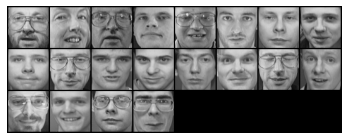

13    31    33    35    30    15    3     11    22    26    29    8     28    17    26    20    16    4     3     19   


In [6]:
def imshow(img):
    img = img     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
from torch.nn.modules.activation import ReLU
class VAE(nn.Module):
    '''
     net = MyAE(img_size=28, embedding_dim=2)
     
     Create an autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.
     
     Inputs:
       img_size       size of input images
                      Input samples will be (img_size**2) vectors.
       embedding_dim  number of nodes in embedding (latent) layer
       
     Usage:
       net = MyAE()
       y = net(x)         # returns output
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, embedding_dim =20):
        super(VAE, self).__init__()
        self.losses =[]
        c_hidden =8
        self.channels =1
        self.encode = nn.Sequential(#64
            nn.Conv2d(self.channels, c_hidden, kernel_size=3, padding=1, stride=1), #64
            nn.BatchNorm2d(c_hidden),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #32
            nn.Conv2d(c_hidden, 2*c_hidden, kernel_size=3, padding=1, stride=1), #32
            nn.BatchNorm2d(2*c_hidden),
            nn.ReLU(),
            nn.Conv2d(2*c_hidden, 4*c_hidden, kernel_size=3, padding=1, stride=1), #32
            nn.BatchNorm2d(4*c_hidden),
            nn.ReLU(),
            nn.Conv2d(4*c_hidden, embedding_dim, kernel_size =3, padding=1, stride =1), #32
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride =2),   #16
        )
        
        self. mu = nn.Linear(20*16*16, embedding_dim)
        self.log_var = nn.Linear(20*16*16, embedding_dim)
        self.linear = nn.Linear(embedding_dim, 20*16*16)


        self.decode = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 4*c_hidden, kernel_size =2, stride=2,padding =0), #8
            nn.BatchNorm2d(4*c_hidden),
            nn.ReLU(),
            nn.ConvTranspose2d(4*c_hidden, c_hidden, kernel_size =3, stride=1,padding =1), #8
            nn.BatchNorm2d(c_hidden),
            nn.ReLU(),
            nn.ConvTranspose2d(c_hidden, self.channels, kernel_size =2, stride=2,padding =0),  #4
            nn.Tanh(),            
        )

    def forward(self, x):
      h = self.encode(x)
      mu= self. mu(h.view(h.size(0),-1))
      log_var = self.log_var(h.view(h.size(0),-1))

      std = torch.exp(log_var/2)
      q = torch.distributions.Normal(mu,std)
      z = q.rsample()
      lin = self.linear(z)
      ha = lin.view(lin.size(0), 20, 16,16)

      return self.decode(ha) , mu, log_var

In [12]:
model = VAE()

In [13]:
#Loss function & Optimizer
criterion = nn.MSELoss()
#criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.7)

In [10]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + 0.000003*KLD

In [14]:
n_epochs = 2000
vae_loss =[]

for epoch in tqdm(range(n_epochs)):
     train_loss = 0.0
     running_loss = 0.0

     for data in trainloader:
         images, _ = data
         optimizer.zero_grad()
         outputs, mu, logvar = model(images)
         bce_loss = criterion(outputs, images)
         loss = final_loss(bce_loss, mu, logvar)
         loss.backward()
         optimizer.step()
         train_loss += loss.item()*images.size(0)
          
     train_loss = train_loss/len(trainloader)
     vae_loss.append(train_loss)


100%|██████████| 2000/2000 [52:20<00:00,  1.57s/it]


Text(0, 0.5, 'Total loss')

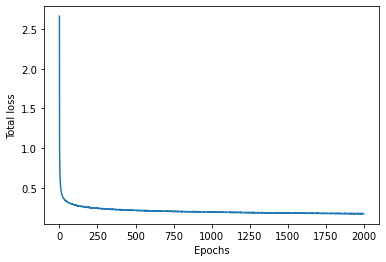

In [53]:
plt.plot(vae_loss)
plt.xlabel ('Epochs')
plt.ylabel('Total loss')

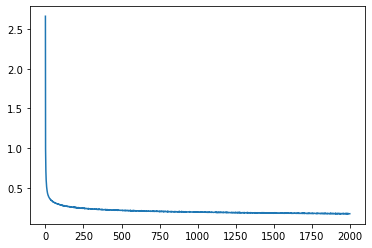

In [52]:
plt.plot(vae_loss)

### Visualize output of the network

original


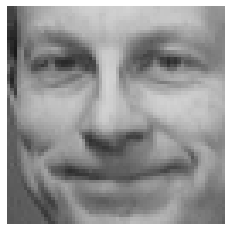

out


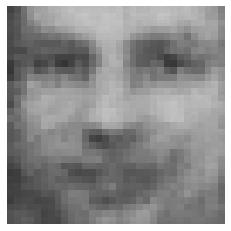

In [16]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
outAE = model(images)[0]
embedded = model.encode(images)
for i in range(len(labels)):
  if labels[i] ==12:
    print('original')
    imshow(torchvision.utils.make_grid(images[i]))
    print('out')
    imshow(torchvision.utils.make_grid(outAE[i]))

original


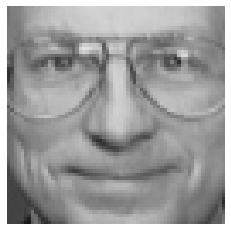

out


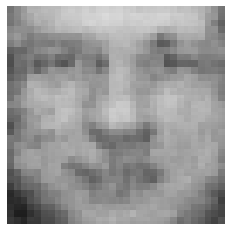

original


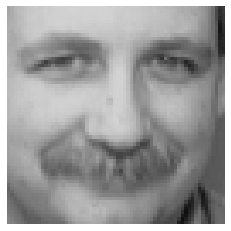

out


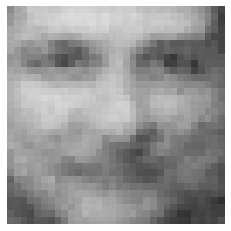

original


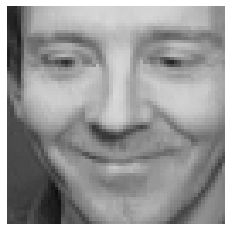

out


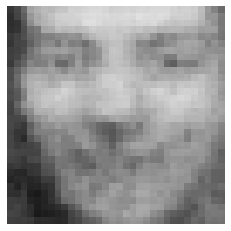

original


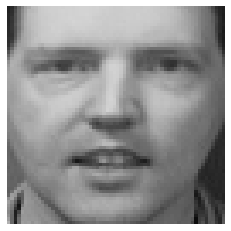

out


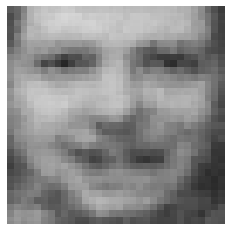

original


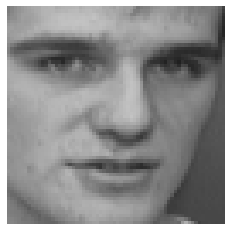

out


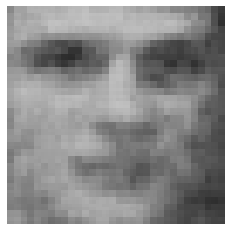

original


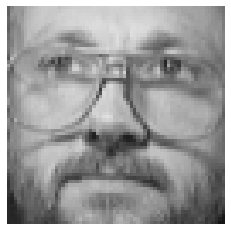

out


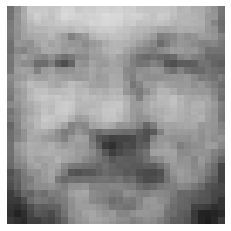

original


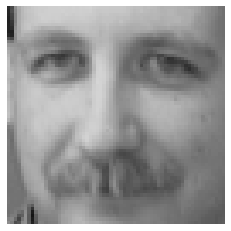

out


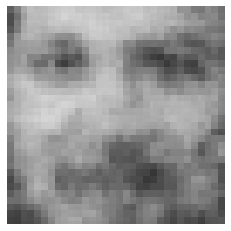

original


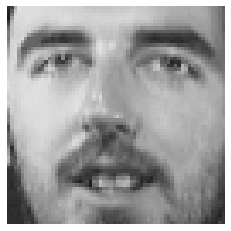

out


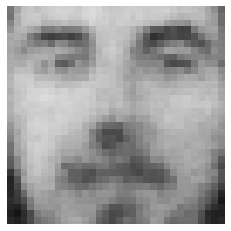

original


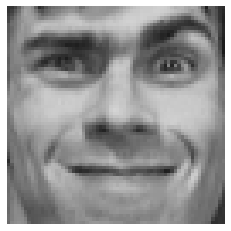

out


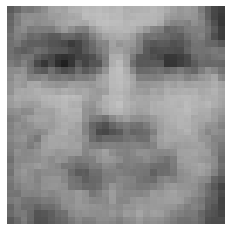

original


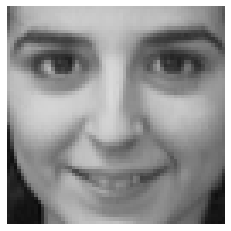

out


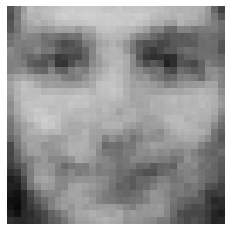

original


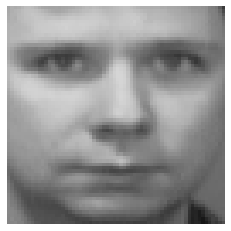

out


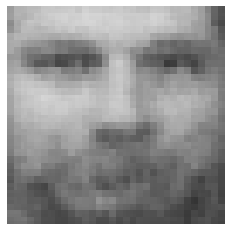

original


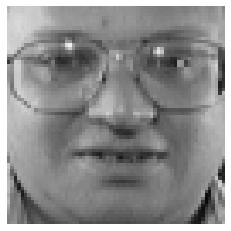

out


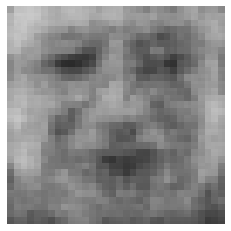

original


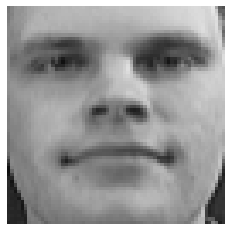

out


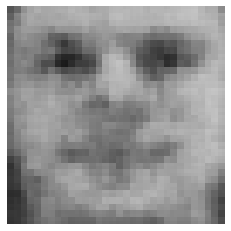

original


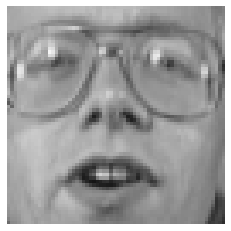

out


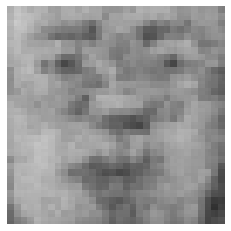

original


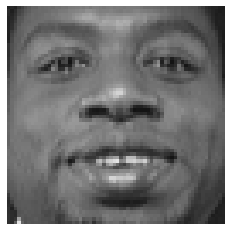

out


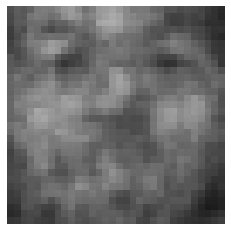

original


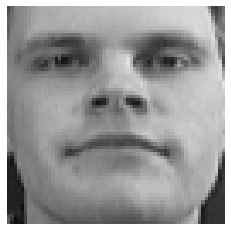

out


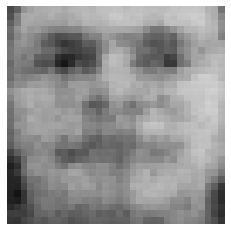

original


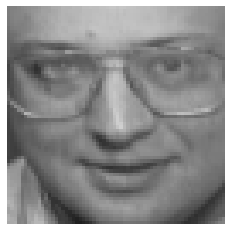

out


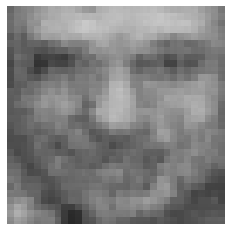

original


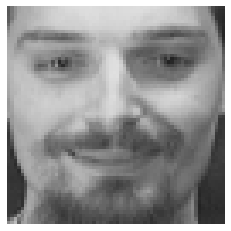

out


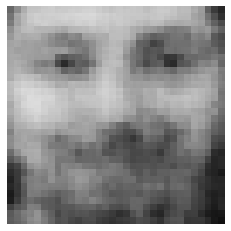

original


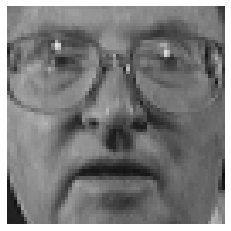

out


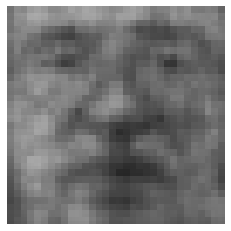

original


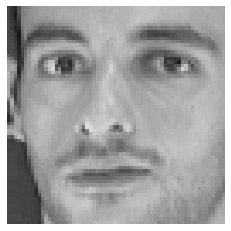

out


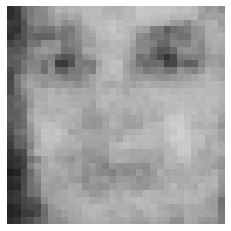

In [17]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
outAE = model(images)[0]
embedded = model.encode(images)
for i in range(len(labels)):
  print('original')
  imshow(torchvision.utils.make_grid(images[i]))
  print('out')
  imshow(torchvision.utils.make_grid(outAE[i]))

### Image Search based on distance

In [18]:
def embedding(model, data_loader):
    """ Encodes all the images in the data loader """
    images = []
    embedded = []
    labels =[]
    for input, label in (data_loader):
        with torch.no_grad():
            z = model.encode(input)
        images.append(input)
        embedded.append(z)
        labels.append(label)
    return (torch.cat(images, dim=0), torch.cat(embedded, dim=0),torch.cat(labels, dim =0))

In [19]:
train_embeds = embedding(model, trainloader)
test_embeds = embedding(model, testloader)

In [20]:
def find_similar_images(distance_type, query_img, query_z, key_embeds, label,K=5):
    """Finds K closest images to the input image based on euclidean distance between the embedded points """
    print('You have selected an image from class ' +str(label.item()) )
    dist =[]
      
    for i in range(len(X_train)):
      distance = torch.cdist(query_z, key_embeds[1][i], p=2)
      d = torch.norm(distance)
      dist.append(d)
    dist = torch.tensor(dist)
    distance, indices = torch.sort(dist)

    index = indices[:K]

    input_image = torch.cat([query_img[None]], dim =0)
    grid_input = torchvision.utils.make_grid(input_image, nrow=1, normalize=True, range=(-1,1))
    print('Selected image')
    grid_input = grid_input.permute(1, 2, 0)
    plt.figure(figsize=(1.5,1.5))
    plt.axis('off')
    plt.imshow(grid_input)
    plt.show()
    print('Similar images are:')
    imgs_to_display = torch.cat([key_embeds[0][indices[:K]]], dim=0)
    index = indices[:K]
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
    c =0

    for i in range(K):
      j = index[i] 
      if key_embeds[2][j].item() == label:
        c+=1

    print(str(c) + ' out of ' + str(K) + ' were correctly identified.')

You have selected an image from class 8
Selected image


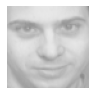

Similar images are:


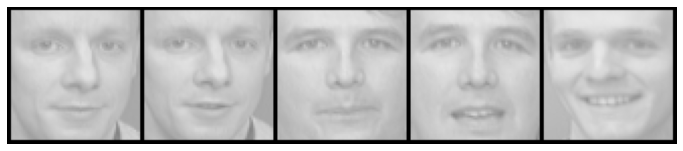

0 out of 5 were correctly identified.


In [22]:
#select a random image in the test set
rand_index = np.random.randint(0, len(test_embeds[0]), 1)
find_similar_images('Euclidean', test_embeds[0][rand_index[0]], test_embeds[1][rand_index[0]],train_embeds, test_embeds[2][rand_index[0]])

### How is the algorithm performing on different groups?

In [23]:
batch_size = 1
trainloader = DataLoader(trainset , batch_size = len(y_train), shuffle=True)
testloader = DataLoader(testset , batch_size = len(y_test), shuffle=True)

In [24]:
def similar_group(distance_type, query_img, query_class, query_z, key_embeds, K=5):
    """Finds K closest images to the input image based on euclidean distance between the embedded points """

    dist =[]
      
    for i in range(len(X_train)):
      distance = torch.cdist(query_z, key_embeds[1][i], p=2)
      d = torch.norm(distance)
      dist.append(d)
    dist = torch.tensor(dist)
    distance, indices = torch.sort(dist)

    index = indices[:K]

    c = []
    for i in index:
      c.append(classes[train_embeds[2][i]])
    count =0
    for i in c:
      if str(i) == query_class:
        count +=1 
    return (count/K)

In [25]:
batch_size = 1
trainloader = DataLoader(trainset , batch_size = batch_size, shuffle=True)
testloader = DataLoader(testset , batch_size = batch_size, shuffle=True)

In [26]:
def get_accuracy(distance_type, query_img, query_z, key_embeds, label,K=1):
    """Finds K closest images to the input image based on euclidean distance between the embedded points """
    dist =[]
      
    for i in range(len(X_test)):
      distance = torch.cdist(query_z, key_embeds[1][i], p=2)
      d = torch.norm(distance)
      dist.append(d)
    dist = torch.tensor(dist)
    distance, indices = torch.sort(dist)

    index = indices[:K]
    c =0

    for i in range(K):
      j = index[i] 
      if key_embeds[2][j].item() == label:
        c+=1

    return c/K

In [27]:
accuracies =[]
for i in range(len(y_test)):
  a = get_accuracy('Euclidean', test_embeds[0][i], test_embeds[1][i],test_embeds, test_embeds[2][i])
  accuracies.append(a)

In [28]:
len(accuracies)

60

In [29]:
sum(i > 0.5 for i in accuracies)

22

### Image search based on 2 images

In [30]:
def encoder(imgs):
    ha = model.encode(imgs)
    mua = model.mu(ha.view(ha.size(0),-1))
    log_vara = model.log_var(ha.view(ha.size(0),-1))
    stda = torch.exp(log_vara/2)
    qa = torch.distributions.Normal(mua,stda)
    za = qa.rsample()
    return za



def decoder(enc):
    #Decodes a point in a latent space back to image
    haa = model.linear(enc)
    hba = haa.view(haa.size(0), 20, 16,16)
    y = model.decode(hba)
    
    return y

def findMidPoint(p, ea, eb):
    mid = (ea + eb)/2
    
    return mid

def findEpsPoint(p, ea, eb):
    newa = p*ea + ((1-p)*eb)
    
    return newa


First image


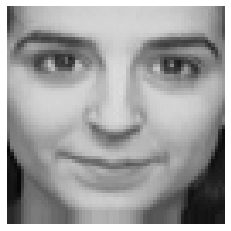

Second image


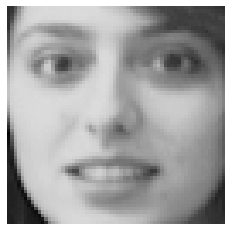

Generated image


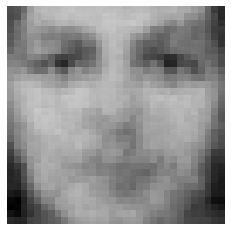

In [31]:
#Batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
print('First image')
imshow(torchvision.utils.make_grid(images[0]))
zspace1 = encoder(images)

imagesa, labelsa = dataiter.next()
print('Second image')
imshow(torchvision.utils.make_grid(imagesa[0]))
zspace2 = encoder(imagesa)

testPoint = findEpsPoint(0.5, zspace1, zspace2)
print('Generated image')
generatedPoint = decoder(testPoint)
imshow(torchvision.utils.make_grid(generatedPoint[0]))

First image


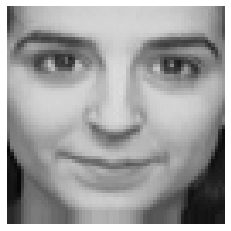

Second image


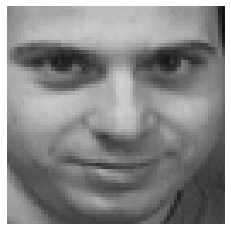

Generated image


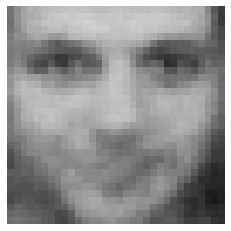

In [32]:
#Batch of test images
true_labels =[]
dataiter = iter(testloader)
images, labels = dataiter.next()
true_labels.append(labels)
print('First image')
imshow(torchvision.utils.make_grid(images[0]))
zspace1 = encoder(images)

imagesa, labelsa = dataiter.next()
true_labels.append(labelsa)
print('Second image')
imshow(torchvision.utils.make_grid(imagesa[0]))
zspace2 = encoder(imagesa)

testPoint = findEpsPoint(0.5, zspace1, zspace2)
print('Generated image')
generatedPoint = decoder(testPoint)

imshow(torchvision.utils.make_grid(generatedPoint[0]))

First image


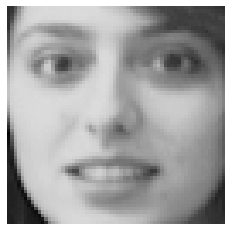

Second image


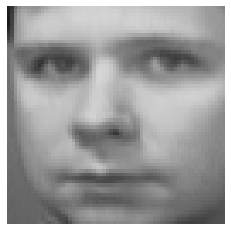

Generated image


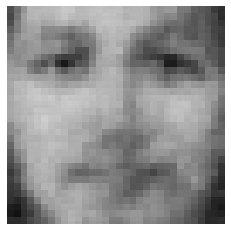

In [33]:
#Batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
print('First image')
imshow(torchvision.utils.make_grid(images[0]))
zspace1 = encoder(images)

imagesa, labelsa = dataiter.next()
print('Second image')
imshow(torchvision.utils.make_grid(imagesa[0]))
zspace2 = encoder(imagesa)

testPoint = findEpsPoint(0.8, zspace1, zspace2)
print('Generated image')
generatedPoint = decoder(testPoint)
imshow(torchvision.utils.make_grid(generatedPoint[0]))

First image


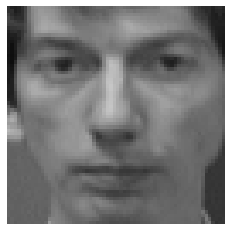

Second image


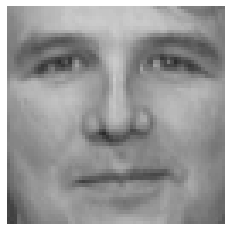

Generated image


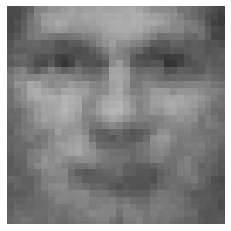

In [54]:
#Batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
print('First image')
imshow(torchvision.utils.make_grid(images[0]))
zspace1 = encoder(images)

imagesa, labelsa = dataiter.next()
print('Second image')
imshow(torchvision.utils.make_grid(imagesa[0]))
zspace2 = encoder(imagesa)

testPoint = findEpsPoint(0.8, zspace1, zspace2)
print('Generated image')
generatedPoint = decoder(testPoint)
imshow(torchvision.utils.make_grid(generatedPoint[0]))

###Vanilla AE

In [51]:
from torch.nn.modules.activation import ReLU
class MyAE(nn.Module):
    '''
     net = MyAE(img_size=28, embedding_dim=2)
     
     Create an autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.
     
     Inputs:
       img_size       size of input images
                      Input samples will be (img_size**2) vectors.
       embedding_dim  number of nodes in embedding (latent) layer
       
     Usage:
       net = MyAE()
       y = net(x)         # returns output
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, embedding_dim =64):
        super(MyAE, self).__init__()
        self.losses =[]
        c_hidden =8
        self.channels =1
        self.encode = nn.Sequential(#64
            nn.Conv2d(self.channels, c_hidden, kernel_size=3, padding=1, stride=1), #64
            nn.BatchNorm2d(c_hidden),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #32
            nn.Conv2d(c_hidden, 2*c_hidden, kernel_size=3, padding=1, stride=1), #32
            nn.BatchNorm2d(2*c_hidden),
            nn.ReLU(),
            nn.Conv2d(2*c_hidden, 4*c_hidden, kernel_size=3, padding=1, stride=1), #32
            nn.BatchNorm2d(4*c_hidden),
            nn.ReLU(),
            nn.Conv2d(4*c_hidden, embedding_dim, kernel_size =3, padding=1, stride =1), #32
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride =2),   #16
        )

        self.decode = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 4*c_hidden, kernel_size =2, stride=2,padding =0), #8
            nn.BatchNorm2d(4*c_hidden),
            nn.ReLU(),
            nn.ConvTranspose2d(4*c_hidden, c_hidden, kernel_size =3, stride=1,padding =1), #8
            nn.BatchNorm2d(c_hidden),
            nn.ReLU(),
            nn.ConvTranspose2d(c_hidden, self.channels, kernel_size =2, stride=2,padding =0),  #4
            nn.Tanh(),
            
        )

    def forward(self, x):
       return self.decode(self.encode(x))

    
    def learn(self, dl, epochs=10, optimizer=None, loss_fcn=None):
        '''
         net.learn(dl, epochs=10, optimizer=None, loss_fcn=None)
         
         Train the network on the dataset delivered by the dataloader dl.
         
         Inputs:
          dl        DataLoader object
          epochs    number of epochs to train
          optimizer PyTorch optimizer function
          loss_fcn  PyTorch loss function
        '''
        if optimizer is None or loss_fcn is None:
            print('Need to specify an optimizer and loss function')
            return

        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                y = self(x)
                loss = loss_fcn(y, x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()*len(t)
                count += 1.
            self.losses.append(total_loss/len(dl.dataset))

        plt.figure(figsize=(6,4))
        plt.plot(self.losses); plt.yscale('log');
        return self.losses


In [40]:
net = MyAE(embedding_dim =20)

In [57]:
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

16837


In [48]:
trainset = TensorDataset(X_train, y_train)
testset = TensorDataset(X_test, y_test)
fullset = TensorDataset(X,y)
batch_size = 20
trainloader = DataLoader(trainset , batch_size = batch_size, shuffle=True)
testloader = DataLoader(testset , batch_size = batch_size, shuffle=True)
trainall = DataLoader(fullset , batch_size = len(X), shuffle=True)

100%|██████████| 2000/2000 [51:06<00:00,  1.53s/it]


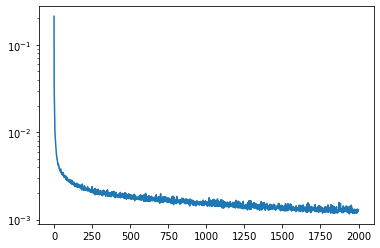

In [42]:
loss_fcn = nn.MSELoss()
optim = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.7)
ae_loss = net.learn(trainloader, epochs = 2000, optimizer = optim, loss_fcn = loss_fcn)

In [43]:
batch_size = 1
trainloader = DataLoader(trainset , batch_size = len(y_train), shuffle=True)
testloader = DataLoader(testset , batch_size = len(y_test), shuffle=True)

In [44]:
train_embeds_ae = embedding(net, trainloader)
test_embeds_ae = embedding(net, testloader)

In [45]:
a = generatedPoint[0].unsqueeze(dim =0)
a.size()

torch.Size([1, 1, 64, 64])

You have selected an image from class 8
Selected image


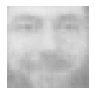

Similar images are:


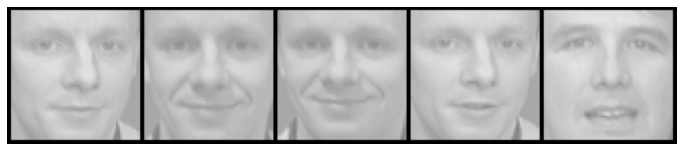

0 out of 5 were correctly identified.


In [46]:
#select a random image in the test set
for i in range(len(generatedPoint)):
  find_similar_images('Euclidean', generatedPoint[i], net.encode(generatedPoint[i].unsqueeze(dim =0)),train_embeds, test_embeds[2][rand_index[0]])

First image


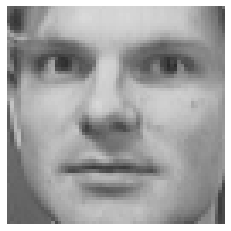

Second image


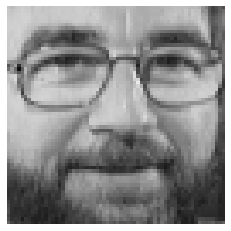

Generated image


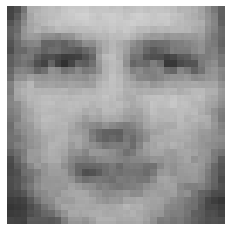

In [49]:
#Batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
print('First image')
imshow(torchvision.utils.make_grid(images[0]))
zspace1 = encoder(images)

imagesa, labelsa = dataiter.next()
print('Second image')
imshow(torchvision.utils.make_grid(imagesa[0]))
zspace2 = encoder(imagesa)

testPoint = findEpsPoint(0.8, zspace1, zspace2)
print('Generated image')
generatedPoint = decoder(testPoint)
imshow(torchvision.utils.make_grid(generatedPoint[0]))

You have selected an image from class 8
Selected image


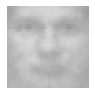

Similar images are:


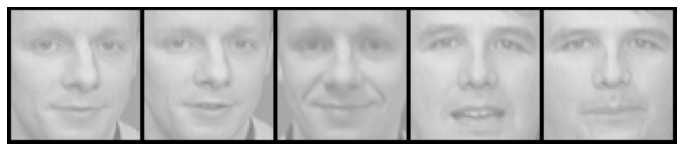

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


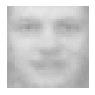

Similar images are:


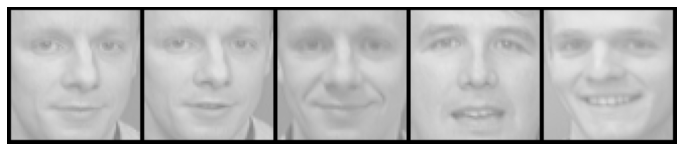

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


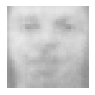

Similar images are:


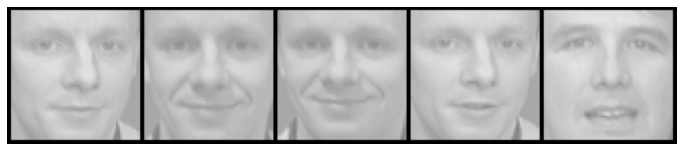

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


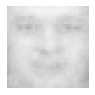

Similar images are:


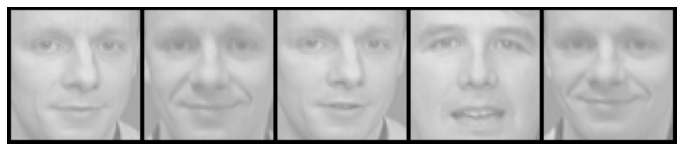

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


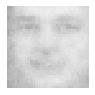

Similar images are:


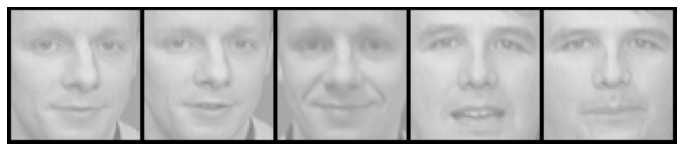

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


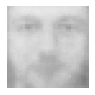

Similar images are:


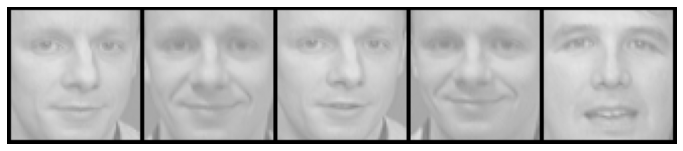

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


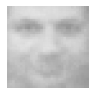

Similar images are:


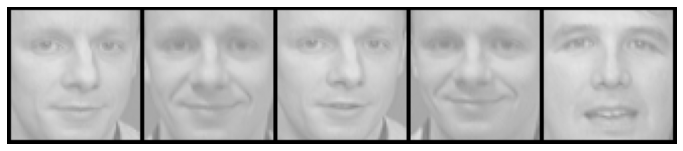

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


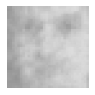

Similar images are:


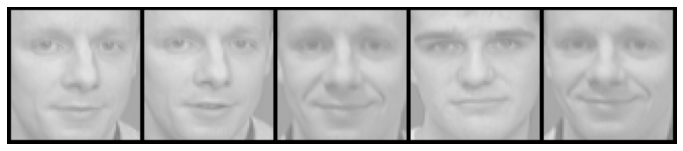

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


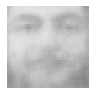

Similar images are:


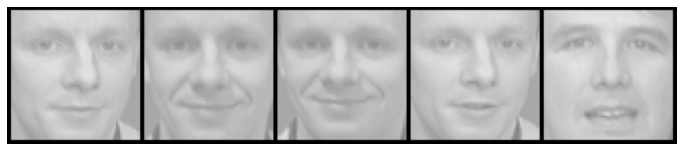

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


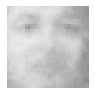

Similar images are:


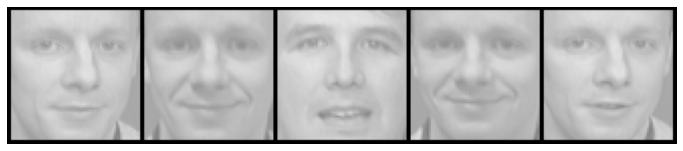

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


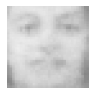

Similar images are:


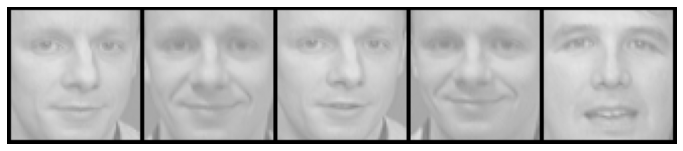

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


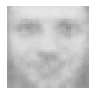

Similar images are:


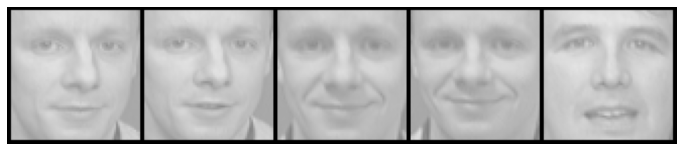

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


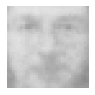

Similar images are:


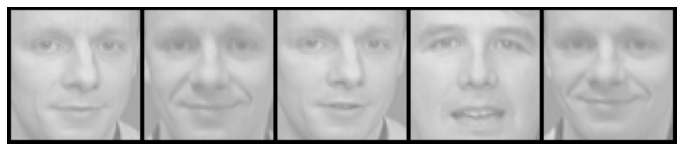

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


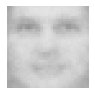

Similar images are:


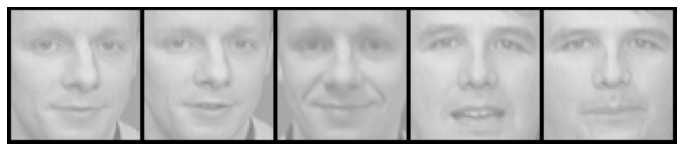

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


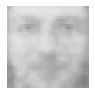

Similar images are:


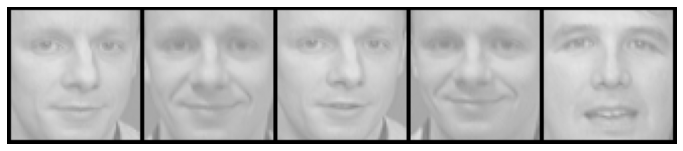

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


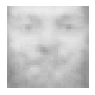

Similar images are:


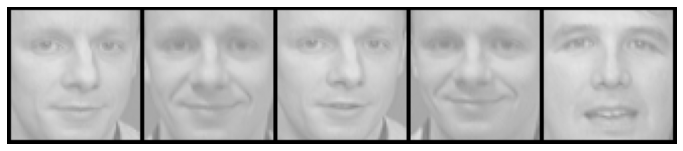

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


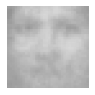

Similar images are:


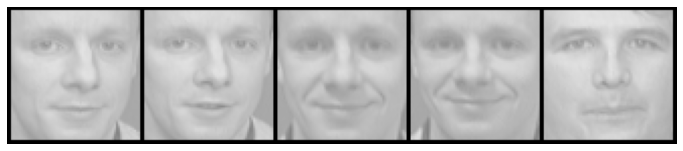

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


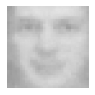

Similar images are:


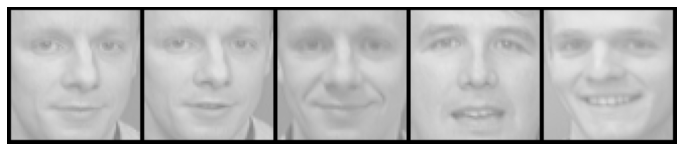

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


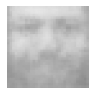

Similar images are:


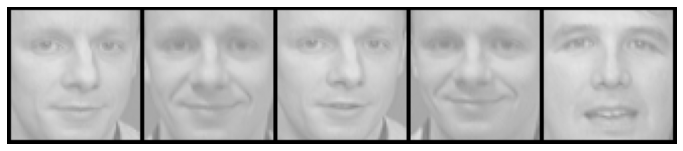

0 out of 5 were correctly identified.
You have selected an image from class 8
Selected image


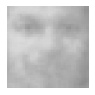

Similar images are:


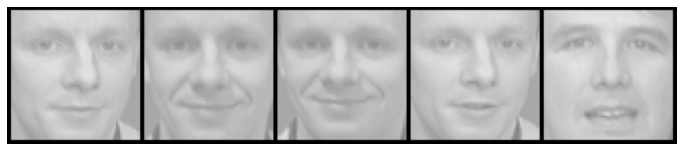

0 out of 5 were correctly identified.


In [55]:
for i in range(len(generatedPoint)):
  find_similar_images('Euclidean', generatedPoint[i], net.encode(generatedPoint[i].unsqueeze(dim =0)),train_embeds, test_embeds[2][rand_index[0]])